In [1]:
import ssl
import warnings
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from scipy.sparse import hstack
import xgboost as xgb
import joblib

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("stopwords")
nltk.download("punkt_tab")

warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", None)
plt.rcParams["figure.figsize"] = (8, 5)

[nltk_data] Downloading package stopwords to /Users/stan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/stan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# EDA

**Purpose:**

- Check for missing data - to ensure data quality and decide if we need to drop any missing rows or impute them appropriately.
- Explore distribution of numerical columns - allows us to decide if we need to apply transformations to any heavily skewed features.
- Explore distribution of target - gives us an idea if class imbalances are present and how we can address this.
- Explore relationships between features.
- Visualize most prominent values for different features e.g. most common words in descriptions.


In [2]:
df = pd.read_csv("../data/wine_quality_1000.csv", index_col=[0])
df.sample()

,country,description,points,price,variety
43110,US,"Very, very sweet in residual sugar, with powerful flavors of apricots, honey, oranges and vanilla. A bit soft, but the luscious sweetness is what makes it work.",88,25.0,Chardonnay


In [3]:
df.isna().sum()

country        0
description    0
points         0
price          0
variety        0
dtype: int64

In [4]:
df.describe()

,points,price
count,1000.000000,1000.000000
mean,87.806000,33.364000
std,3.369825,28.634235
min,80.000000,6.000000
25%,85.000000,18.000000
50%,88.000000,25.000000
75%,90.000000,40.000000
max,98.000000,463.000000


In [5]:
df.nunique()

country          4
description    998
points          19
price           82
variety        105
dtype: int64

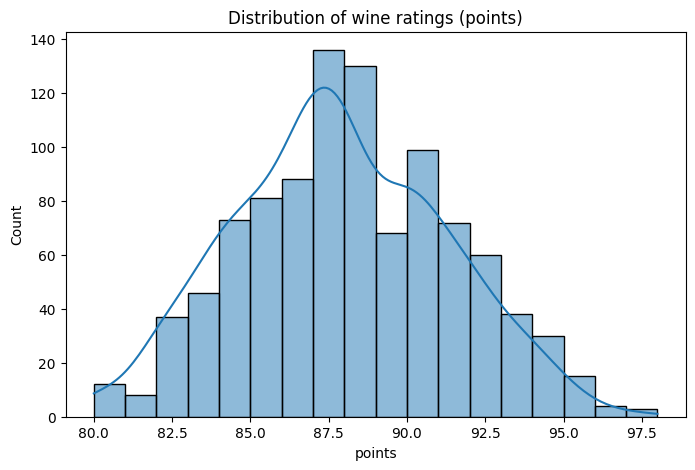

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(df["points"], kde=True)
plt.title("Distribution of wine ratings (points)");

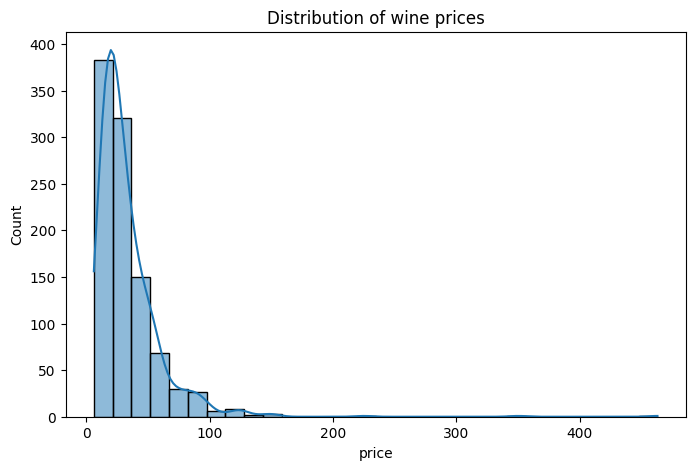

In [7]:
sns.histplot(df["price"], bins=30, kde=True)
plt.title("Distribution of wine prices");

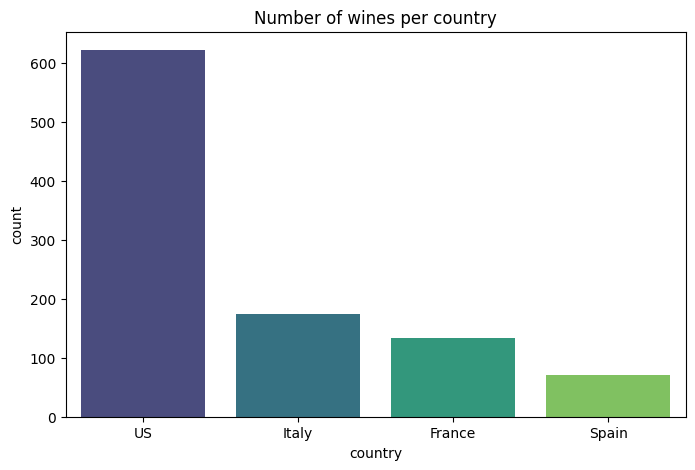

In [8]:
sns.countplot(
    data=df, x="country", order=df["country"].value_counts().index, palette="viridis"
)
plt.title("Number of wines per country");

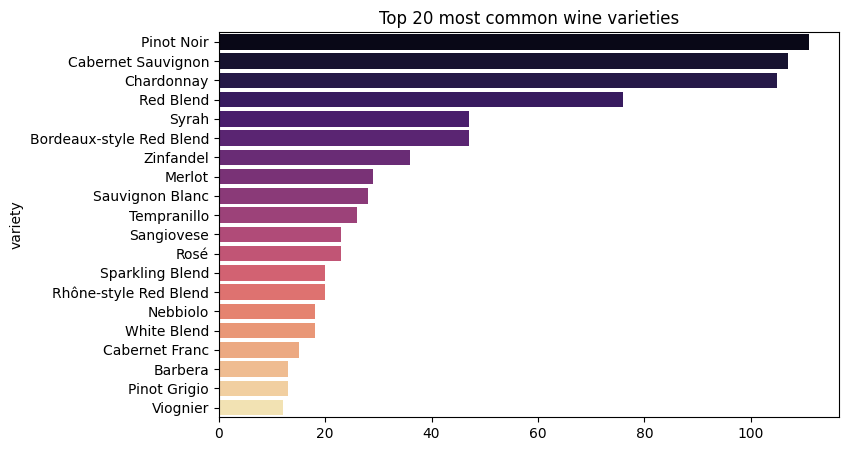

In [9]:
top_varieties = df["variety"].value_counts().nlargest(20)
sns.barplot(x=top_varieties.values, y=top_varieties.index, palette="magma")
plt.title("Top 20 most common wine varieties");

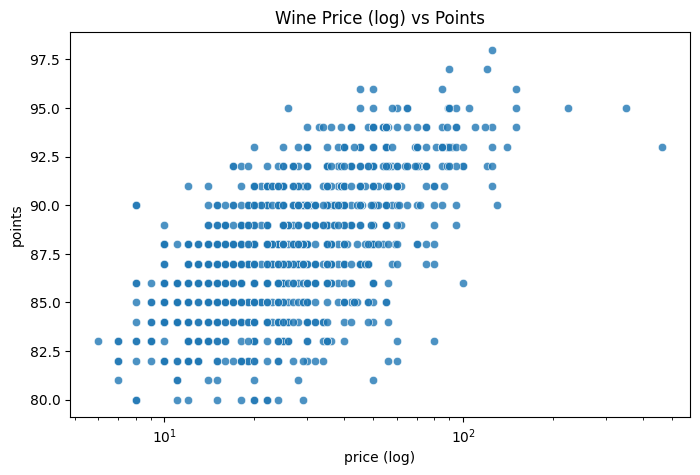

In [10]:
sns.scatterplot(data=df, x="price", y="points", alpha=0.8)
plt.xscale("log")
plt.title("Wine Price (log) vs Points")
plt.xlabel("price (log)");

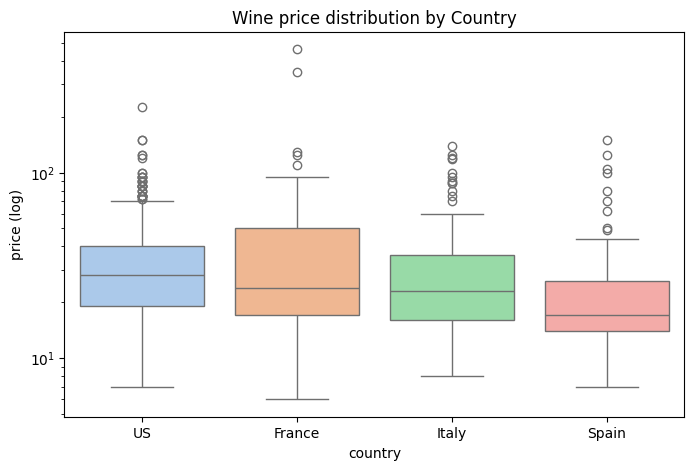

In [11]:
sns.boxplot(data=df, x="country", y="price", palette="pastel")
plt.yscale("log")
plt.ylabel("price (log)")
plt.title("Wine price distribution by Country");

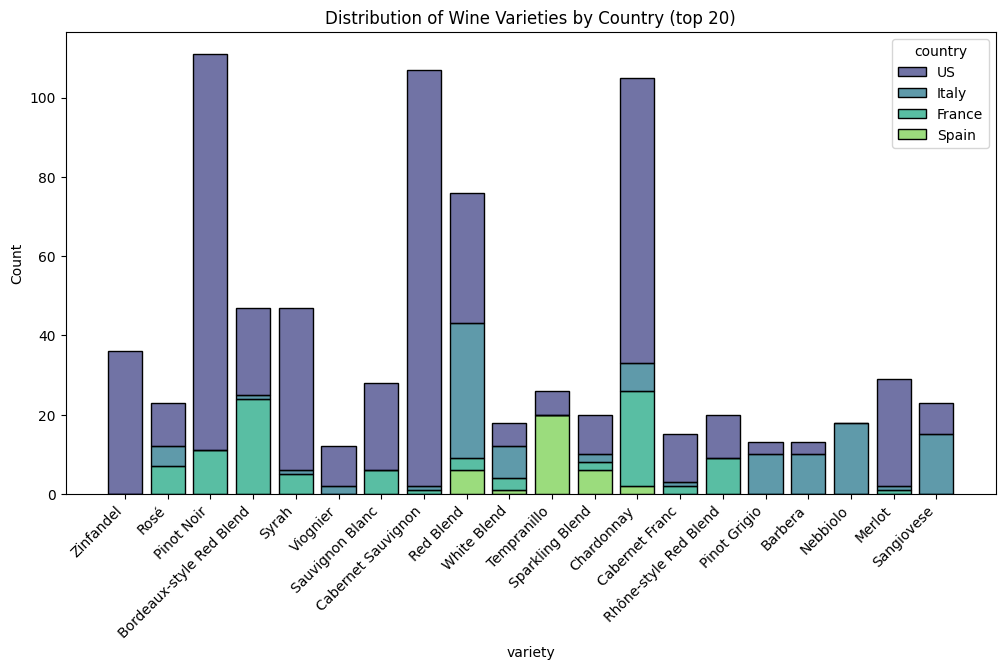

In [12]:
plt.figure(figsize=(12, 6))
top_varieties_list = top_varieties.index
df_top_varieties = df[df["variety"].isin(top_varieties_list)]
sns.histplot(
    data=df_top_varieties,
    x="variety",
    hue="country",
    multiple="stack",
    palette="viridis",
    shrink=0.8,
)
plt.title("Distribution of Wine Varieties by Country (top 20)")
plt.xticks(rotation=45, ha="right");

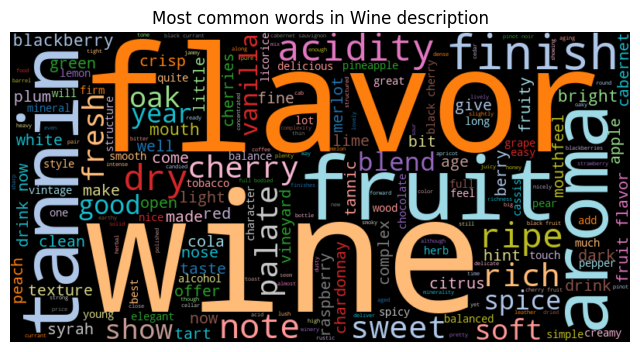

In [13]:
text = " ".join(df["description"]).lower()
wordcloud = WordCloud(width=800, height=400, colormap="tab20_r").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Most common words in Wine description")
plt.axis("off");

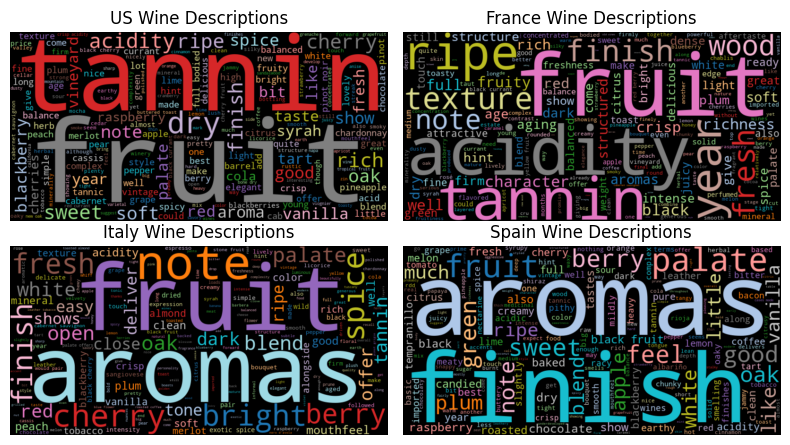

In [14]:
stop_words = set(stopwords.words("english"))
stop_words.update(
    [
        "wine",
        "drink",
        "bottle",
        "glass",
        "flavor",
        "flavors",
        "mouth",
        "nose",
        "alcohol",
    ]
)

countries = list(df.country.unique())
for idx, country in enumerate(countries):
    text = " ".join(df[df["country"] == country]["description"]).lower()
    wordcloud = WordCloud(
        width=800, height=400, colormap="tab20_r", stopwords=stop_words
    ).generate(text)
    plt.subplot(2, 2, idx + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{country} Wine Descriptions")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [15]:
tokenized_text = [
    [
        word
        for word in word_tokenize(desc.lower())
        if word.isalnum() and word not in stop_words
    ]
    for desc in df["description"]
]

bigrams = [bigram for desc in tokenized_text for bigram in ngrams(desc, 2)]
bigram_counts = Counter(bigrams).most_common(10)
bigram_counts

[(('black', 'cherry'), 38),
 (('cabernet', 'sauvignon'), 37),
 (('pinot', 'noir'), 33),
 (('crisp', 'acidity'), 24),
 (('cherry', 'fruit'), 22),
 (('blackberry', 'cherry'), 20),
 (('tropical', 'fruit'), 18),
 (('new', 'oak'), 18),
 (('buttered', 'toast'), 18),
 (('black', 'fruit'), 17)]

In [16]:
trigrams = [trigram for desc in tokenized_text for trigram in ngrams(desc, 3)]
trigram_counts = Counter(trigrams).most_common(10)
trigram_counts

[(('new', 'french', 'oak'), 8),
 (('next', 'six', 'years'), 7),
 (('black', 'cherry', 'fruit'), 6),
 (('blend', 'cabernet', 'sauvignon'), 6),
 (('cherries', 'red', 'currants'), 6),
 (('cabernet', 'sauvignon', 'merlot'), 5),
 (('aged', 'stainless', 'steel'), 4),
 (('sweet', 'smoky', 'oak'), 4),
 (('cabernet', 'sauvignon', 'cabernet'), 4),
 (('sauvignon', 'cabernet', 'franc'), 4)]

# Data Preprocessing

- Log transform `price` tp handle its skewed distribution.
- Encode categorical variables OneHotEncoder for `variety` and LabelEncoder for `country`.
- Remove stop words to focus on meanignful terms.
- Use TF-IDF (Term Frequency-Inverse Document Frequency) to vectorize the text descriptions, which helps in capturing the importance of words in the context of the dataset.
- Split the data into training and testing sets (80-20 split) while ensuring stratification by the target variable (country) to maintain class distribution.


In [17]:
df['log_price'] = np.log1p(df['price'])

In [18]:
y = df["country"]
X = df.drop(columns=["country", "price"])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(
    stop_words=list(stop_words), max_features=8000, ngram_range=(1, 2)
)

X_train_description = tfidf.fit_transform(X_train["description"])
X_test_description = tfidf.transform(X_test["description"])

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

ohp = OneHotEncoder(handle_unknown='ignore')
X_train_variety = ohp.fit_transform(X_train[["variety"]])
X_test_variety = ohp.transform(X_test[["variety"]])

X_train_numerical = X_train[["log_price", "points"]].values
X_test_numerical = X_test[["log_price", "points"]].values

X_train_combined = hstack([X_train_description, X_train_variety, X_train_numerical])
X_test_combined = hstack([X_test_description, X_test_variety, X_test_numerical])

# Model training

- Train an XGB classifier, a powerful gradient boosting algorithm.
- The model is configured to handle multi-class classification (`objective='multi:softmax`) and uses inverse frequency penalisation to address class imbalance.


In [20]:
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    learning_rate=0.1,
    n_estimators=200,
    max_depth=6,
    random_state=42,
    scale_pos_weight=[0.4026, 1.4368, 1.8797, 3.5239] 
)

xgb_classifier.fit(X_train_combined, y_train_encoded)
y_pred = xgb_classifier.predict(X_test_combined)

# Evaluation

- Compute metrics such as F1 score, accuracy, precision, and recall to assess the model's performance.
- Generate a classification report to provide detailed insights into the model's predictions for each class.


In [21]:
report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_)
f1_weighted = f1_score(y_test_encoded, y_pred, average='weighted')
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')

print("Classification Report:\n", report)
print(f"Weighted F1 Score: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")

Classification Report:
               precision    recall  f1-score   support

      France       0.75      0.56      0.64        27
       Italy       1.00      0.69      0.81        35
       Spain       0.75      0.21      0.33        14
          US       0.79      0.97      0.87       124

    accuracy                           0.81       200
   macro avg       0.82      0.61      0.66       200
weighted avg       0.82      0.81      0.79       200

Weighted F1 Score: 0.7910
Accuracy: 0.8100
Weighted Precision: 0.8182
Weighted Recall: 0.8100


# Creating a pipeline

- I created a machine learning pipeline to streamline the preprocessing and modeling steps. The pipeline ensures that all transformations and model training and performed in a consistent and reproducible manner.
- By combining all steps into a single pipeline, we avoid the need to manually apply transformations during inference.
- The pipeline can be easily deployed to productions environments (e.g., AWS Lambda) for real time predictions.


In [22]:
set_config(display='diagram') 

def preprocess_pipeline():
    """
    Returns a ColumnTransformer fitted on the entire dataset for consistent feature dimensions.
    """
    return ColumnTransformer([
        ('text', TfidfVectorizer(stop_words=list(stop_words), max_features=8000, ngram_range=(1, 2)), 'description'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['variety']),
        ('num', 'passthrough', ['log_price', 'points'])
    ])


In [23]:
def train_evaluate_split(df):
    """Trains and evaluates the model on a train-test split"""

    df['log_price'] = np.log1p(df['price'])
    y = df['country']
    X = df.drop(columns=['country', 'price'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    preprocessor = preprocess_pipeline()
    preprocessor.fit(X_train) # Fit preprocessor on training data only to avoid data leakage

    xgb_classifier = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(label_encoder.classes_),
        learning_rate=0.1,
        n_estimators=200,
        max_depth=6,
        random_state=42,
        scale_pos_weight=[0.4026, 1.4368, 1.8797, 3.5239]
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb_classifier)
    ])

    # evaluate the model
    pipeline.fit(X_train, y_train_encoded)
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_)
    f1_weighted = f1_score(y_test_encoded, y_pred, average='weighted')
    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision = precision_score(y_test_encoded, y_pred, average='weighted')
    recall = recall_score(y_test_encoded, y_pred, average='weighted')

    print("Classification Report:\n", report)
    print(f"Weighted F1 Score: {f1_weighted:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")

    return pipeline, label_encoder

In [24]:
def cross_validate_with_importance(df, n_splits=5):
    """Performs stratified cross-validation adn computes average feature importance"""

    df['log_price'] = np.log1p(df['price'])
    y = df['country']
    X = df.drop(columns=['country', 'price'])

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    preprocessor = preprocess_pipeline()
    preprocessor.fit(X)  

    xgb_classifier = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(label_encoder.classes_),
        learning_rate=0.1,
        n_estimators=200,
        max_depth=6,
        random_state=42,
        scale_pos_weight=[0.4026, 1.4368, 1.8797, 3.5239]
    )

    # cross val setup
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, test_idx in cv.split(X, y_encoded):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        # Transform data using preprocessor
        X_train_transformed = preprocessor.transform(X_train)
        X_test_transformed = preprocessor.transform(X_test)

        # Train the model
        xgb_classifier.fit(X_train_transformed, y_train)
        y_pred = xgb_classifier.predict(X_test_transformed)

        # Compute F1 score
        f1 = round(f1_score(y_test, y_pred, average='weighted'),4)
        cv_scores.append(f1)

    print("Cross-Validation F1 Weighted Scores:", cv_scores)
    print(f"Mean CV F1 Weighted Score: {np.mean(cv_scores):.4f}")


    final_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb_classifier)
    ])
    final_pipeline.fit(X, y_encoded)

    return final_pipeline, label_encoder

In [28]:
wine_data = pd.read_csv("../data/wine_quality_1000.csv")
# Train and evaluate on a single split
pipeline, label_encoder = train_evaluate_split(wine_data)

# Perform cross-validation
pipeline, label_encoder = cross_validate_with_importance(wine_data)

joblib.dump(pipeline, '../model/wine_classification_pipeline.pkl')
joblib.dump(label_encoder, '../model/label_encoder.pkl')

Classification Report:
               precision    recall  f1-score   support

      France       0.75      0.56      0.64        27
       Italy       1.00      0.69      0.81        35
       Spain       0.75      0.21      0.33        14
          US       0.79      0.97      0.87       124

    accuracy                           0.81       200
   macro avg       0.82      0.61      0.66       200
weighted avg       0.82      0.81      0.79       200

Weighted F1 Score: 0.7910
Accuracy: 0.8100
Weighted Precision: 0.8182
Weighted Recall: 0.8100
Cross-Validation F1 Weighted Scores: [0.7639, 0.8049, 0.8277, 0.8169, 0.8102]
Mean CV F1 Weighted Score: 0.8047


['../model/label_encoder.pkl']

# Use of LLMs vs Classical NLP

1. Using LLM generated summaries

   - Instead of using TF-IDF for the original `description` feature we can instead use an LLM to provide concise summaries.
   - Summaries could reduce noise and reduce dimensionality compared to using full descriptions, potentially improving model performance.

2. Generate embeddings for descriptions using LLMs

   - We could generate vector embeddings for each description
   - Embeddings can be fed directly into the XGBoost model.
   - However the dataset only has 1000 rows and embeddings work much better with larger datasets.

3. LLMs for imputing missing descriptions
   - Luckily this dataset does not have any missing descriptions or data.
   - But if we did have missing descriptions we could combine existing descriptions as examples along with some prompt engineering to avoid discarding rows or leaving them empty.
   - e.g. "Generate a short wine description for {variety} wine from {country} priced at {price} with a rating of {points}/


In [30]:
import requests
import json
import os
from dotenv import load_dotenv

load_dotenv()
API_KEY = os.getenv('API_KEY')
API_URL = os.getenv('API_URL')


headers = {'x-api-key': API_KEY,
           'Content-Type': 'application/json'}


def get_llm_summary(text, model="gpt-4o-mini"):
    payload = {
        "model": model,
        "messages": [{"role": "user", "content": f"Give a concise summary of this wine review in 10 words or less: {text}"}],
        "max_tokens": 50  
    }

    response = requests.post(API_URL, headers=headers, data=json.dumps(payload))
    
    if response.status_code == 200:
        return response.json()['choices'][0]['message']['content']
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

sample_descriptions = wine_data['description'].sample(5)

for desc in sample_descriptions:
    summary = get_llm_summary(desc)
    print(f"Original: {desc}\nSummary: {summary}\n{'-'*80}")

Original: We suggest very little time with this bulky, medicinal Tempranillo. Despite color and weight, it's prickly, sour and not too ripe. The flavors and finish are short, while the overriding impression is that it's underdeveloped.
Summary: Bulky, sour Tempranillo; underdeveloped with short flavors.
--------------------------------------------------------------------------------
Original: For an $18 Oregon Pinot, you can't do much better than this well-made wine from a top-flight vintage. Brambly black cherry fruit carries a streak of cola, with ripe, moderate tannins balancing out a medium-long finish.
Summary: Excellent Oregon Pinot with black cherry, cola, and balanced tannins.
--------------------------------------------------------------------------------
Original: Fogarty's basic '05 Chard shows an exciting crispness and minerality that, good as it is, makes you long for the single-vineyard bottlings to come. There's an elegant angularity to the wine despite the succulent pin

In [ ]:
def get_llm_embedding(text, model="text-embedding-ada-002"):  
    payload = {
        "model": model,
        "input": text
    }

    response = requests.post(API_URL + "/embeddings", headers=headers, data=json.dumps(payload))
    
    if response.status_code == 200:
        return response.json()['data'][0]['embedding']  
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

sample_descriptions = wine_data['description'].sample(5)

for desc in sample_descriptions:
    embedding = get_llm_embedding(desc)
    print(f"Original: {desc}\nEmbedding: {embedding[:5]}... (first 5 values)\n{'-'*80}")